In [29]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import skimage
import random
import cv2
import heapq
import time
import torch

from src.frechetdist import frdist
from src.refine_transform import match_fragments, Translation,check_possibility_of_translation, compute_fast_geom_morph_score,nms

from src.utils import *
from src.shape_align import *
from src.find_transform import *
from src.shape_utils import *
from src.curvature import edge_coords2curvatures
from src.refine_transform import *
from src.visualize import *

from typing import List, Dict, Tuple
from joblib import Parallel, delayed
from skimage.color import rgb2lab, lab2rgb
from tqdm import tqdm
from dataclasses import dataclass
from scipy.ndimage import shift

In [3]:
data_dir = '../../dataset'
palette = np.array([[4.83058360e+01, -4.28336049e+00, -1.04226657e+00],
                    [7.28763389e+01,  1.10190913e+01,  2.91083397e+01],
                    [1.93975643e+01,  8.21757008e+00, -6.52862709e+00],
                    [6.12470461e+01,  6.38868771e+00,  1.05191202e+01],
                    [8.70237508e+01,  2.60029629e+00,  6.34060233e+00],
                    [3.84328672e+01,  2.22768163e+01,  1.17465682e+00],
                    [3.29131583e+01,  3.06846260e-02, -6.19825618e+00]])

In [4]:
frag1 = pad_fragment_to_size(build_fragment_from_directory(data_dir + '/95'), 200)
frag2 = pad_fragment_to_size(build_fragment_from_directory(data_dir + '/103'), 200)

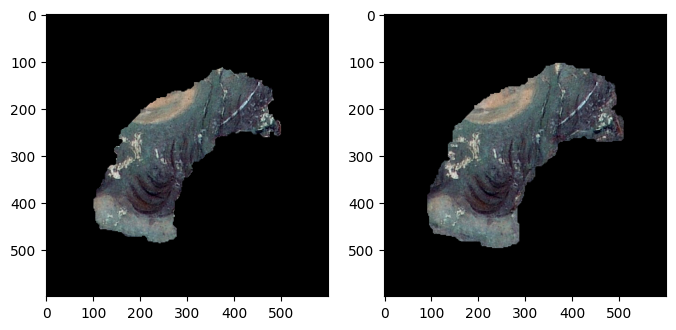

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
axes[0].imshow(frag2.fragment)
axes[1].imshow(frag2.extended_frag)

# Matching fragments

In [6]:
# def find_best_fragment_transform(palette, frag1, frag2):
#     frags = [frag1, frag2]
#     descriptors, alignment = pairwise_alignment(palette, frags)
#     line1 = aligned_coords2line(alignment[(0, 1)], descriptors[0].edge_coords, left=True)
#     line2 = aligned_coords2line(alignment[(0, 1)], descriptors[1].edge_coords[::-1], left=False)
#     line1 -= frag1.fragment.shape[0] // 2
#     line2 -= frag2.fragment.shape[0] // 2
#     best_transform = find_best_transform_ransac(line1, line2)
#     return best_transform, line1, line2 

# def estimate_max_squared_transformation_error(line1, line2, trasform_params):
#     """
#     line1, line2 - np.arrays, shape (n, 2)
#     transforms_params - tuple (cos, sin, a, b) of transform parameters line1 -> line2
#     returns mean squared error
#     """
#     transformed_line1 = transform_line(line1, trasform_params)
#     return np.linalg.norm(line2 - transformed_line1, axis=1).max()

# def iou(indices1, indices2):
#     set1 = set([tuple(p) for p in indices1])
#     set2 = set([tuple(p) for p in indices2])
#     iou = len(set1.intersection(set2)) / len(set1.union(set2))
#     return iou

# def alignment_nms(aligns, edge_coords1, edge_coords2):
#     aligns.sort(key=lambda x: x.conf, reverse=False)
#     align_coords1 = [aligned_coords2line(aligns[i].indices, edge_coords1, left=True) for i in range(len(aligns))]
#     align_coords2 = [aligned_coords2line(aligns[i].indices, edge_coords2[::-1], left=False) for i in range(len(aligns))]
#     i = 0
#     while i < len(aligns):
#         j = i + 1
#         while j < len(aligns):
#             iou_score = (iou(align_coords1[i], align_coords1[j]) + iou(align_coords2[i], align_coords2[j])) / 2
            
# #             print(i, '-', j, ':', iou_score)
#             if iou_score > 0.9:
#                 aligns.pop(j)
#             else:
#                 j += 1
#         i += 1
#     return aligns

# def backtrace(
#     pointer,
#     score,
#     seq1, seq2,
#     block_i, block_j, 
#     block_size_y, block_size_x
# ):
#     roi = score[block_i * block_size_y : (block_i + 1) * block_size_y, block_j * block_size_x : (block_j + 1) * block_size_x]
#     argmax = np.argmax(roi)
#     max_i, max_j = np.unravel_index(argmax, roi.shape)
#     max_i, max_j = max_i + block_i * block_size_y, max_j + block_j * block_size_x
# #     print(roi.shape, roi.max(), argmax, max_i, max_j)
    
#     indices = []
#     i, j = max_i, max_j
#     while pointer[i][j] > 0:
#         indices.append((i, j))
#         if pointer[i][j] == 3:
#             i -= 1
#             j -= 1
#         elif pointer[i][j] == 2:
#             j -= 1
#         elif pointer[i][j] == 1:
#             i -= 1
#     return np.array(indices)

# def generate_multiple_alignments(pointer, score, dsc1, dsc2, blocks_num):
#     block_size_y = int(pointer.shape[0] / blocks_num)
#     block_size_x = int(pointer.shape[1] / blocks_num)
#     color_edge1 = dsc1.color_edge
#     color_edge2 = dsc2.color_edge
#     edge_coords1 = dsc1.edge_coords
#     edge_coords2 = dsc2.edge_coords

#     best_indices = None
#     best_mse = 10000
#     aligns = []
#     for i in range(blocks_num):
#         for j in range(blocks_num):
#             indices = backtrace(pointer, score, color_edge1, color_edge2[::-1], i, j, block_size_y, block_size_x)
#             if len(indices) < 25:
#                 continue
#             line1 = aligned_coords2line(indices, edge_coords1, left=True)
#             line2 = aligned_coords2line(indices, edge_coords2[::-1], left=False)
#             best_transform = find_best_transform_ransac(line1, line2)
#             if best_transform is None:
#                 continue
#             mse = estimate_max_squared_transformation_error(line1, line2, best_transform)
#             aligns.append(Alignment(indices, mse))
#     print(len(aligns))
#     aligns = alignment_nms(aligns, edge_coords1, edge_coords2)
#     print(len(aligns))
#     return aligns

# def new_pairwise_alignment(palette, fragments: List, blocks_num=5) -> Tuple[List[ShapeDescriptor], Dict[Tuple[int, int], np.ndarray]]:
#     """Compute pairwise alignment between fragments.

#     Args:
#         fragments: List of fragments.
#     """
#     print("Computing shape descriptors...")
#     shape_descriptors = fragments2shape_descriptors(palette, fragments)
#     print("Computing pairwise alignments...")
#     alignment_dict = {}
#     for i, frag1 in enumerate(fragments):
#         for j, frag2 in enumerate(fragments):
#             if j > i:
#                 indices, pointer, score = align_two_fragments(
#                     palette,
#                     frag1, frag2, 
#                     to_print=f"Aligning fragments {i} and {j}:", 
#                     shape_descriptor1=shape_descriptors[i], 
#                     shape_descriptor2=shape_descriptors[j]
#                 )
#                 aligns = generate_multiple_alignments(pointer, score, shape_descriptors[i], shape_descriptors[j], blocks_num)
#                 alignment_dict[(i, j)] = aligns
    
#     return shape_descriptors, alignment_dict

In [7]:
frags = [frag1, frag2]


In [8]:
descriptors, alignment = new_pairwise_alignment(palette,frags, blocks_num=5)

Computing shape descriptors...
Computing pairwise alignments...
Aligning fragments 0 and 1:
new diag score is estimated


100%|██████████████████████████████████████████████████████████████████████████████| 1878/1878 [00:10<00:00, 182.26it/s]


21
5


In [10]:
align_index = 0
l, r = 0, 1

In [33]:
# def transform_line(line, trasform_params):
#     """
#     line - np.array, shape (n, 2)
#     trasform_params - tuple (cos, sin, a, b) of transform parameters line -> line
#     returns transformed line
#     """
#     cos, sin, a, b = trasform_params
#     cos = min(cos, 1)
#     cos = max(cos, -1)
#     sin = np.sqrt(1 - cos**2) if sin > 0 else -np.sqrt(1 - cos**2)
#     transformed_line = np.zeros(line.shape)
#     transformed_line[:, 0] = line[:, 0] * cos - line[:, 1] * sin + a
#     transformed_line[:, 1] = line[:, 0] * sin + line[:, 1] * cos + b
#     return transformed_line


In [34]:
# def find_best_transform_ransac(line1, line2):
#     length = min(line1.shape[0], line2.shape[0])
#     min_error = 10000
#     best_transform = None
    
#     for i in range(1000):
#         l = random.choice(range(length))
#         if (length - l) <= 25: 
#             continue
#         r = random.choice(range(l + 25, length))
#         if r - l < 25: 
#             continue
#         try: 
#             dist = np.linalg.norm(line1[l] - line1[r])
#             distances = np.abs(np.linalg.norm(line2 - line2[l], axis=1) - dist)
#             distances[:l] = 10000
#             best_point = np.argmin(distances)
            
#             transform_params = estimate_transform_params(line1[l], line1[r], line2[l], line2[best_point])
#         except Exception as e:
# #             raise e
#             continue
#         error = estimate_max_squared_transformation_error(line1, line2, transform_params)
        
#         if error < min_error:
# #             print("new best error", error, "at ", l, r, " with ", transform_params)
# #             print(line1[l], line1[r], line2[l], line2[best_point], np.linalg.norm(line1[l] - line1[r]), np.abs(np.linalg.norm(line2[l] - line2[best_point])))
#             min_error = error
#             best_transform = transform_params
#     return best_transform

In [13]:
# def normalize_fragment(frag):
#     return Fragment(
#         frag.fragment / 255,
#         frag.extended_frag / 255,
#         frag.mask / 255,
#         frag.extended_mask / 255,
#         frag.color_descriptor,
#         frag.edge_coords,
#         frag.edge_colors
#     )

In [14]:
# blended = blend_fragments(
#     normalize_fragment(pad_fragment_to_size(frag2, 300)),
#     shift_fragment(
#         rotate_fragment(pad_fragment_to_size(frag1, 300), theta), 
#         int(shift_x),
#         int(shift_y)
#     )
# )
# plt.imshow(blended.fragment)/


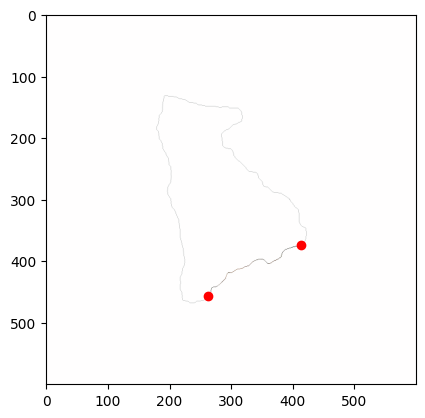

In [15]:
# common_edge = np.ones((frags[l].fragment.shape[0] * 2, frags[l].fragment.shape[1] * 2, 3))
common_edge = np.ones(frags[l].fragment.shape)
color_edge, edge_coords, curvs = descriptors[l].color_edge, descriptors[l].edge_coords, descriptors[l].curvatures
indices = alignment[(l, r)][align_index].indices
i_indices = [i for (i, j) in indices]
for i, point in enumerate(edge_coords):
#     print(point)
    common_edge[point[0], point[1]] = 0.8
common_edge = rgb2lab(common_edge)
    
for (i, j) in indices:
    color = color_edge[i - 1]
    y, x = edge_coords[i - 1]
    common_edge[y, x] = color

plt.imshow(lab2rgb(common_edge))
common_edge = lab2rgb(common_edge)
y1, x1 = edge_coords[indices[0][0] - 1]
y2, x2 = edge_coords[indices[-1][0] - 1]
plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)

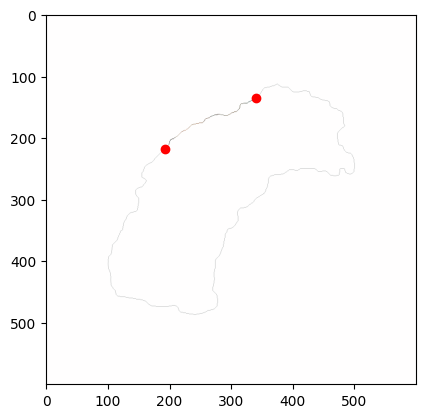

In [16]:
common_edge = np.ones(frags[r].fragment.shape)
color_edge, edge_coords, curvs = descriptors[r].color_edge[::-1], descriptors[r].edge_coords[::-1], descriptors[r].curvatures[::-1]
indices = alignment[(l, r)][align_index].indices
i_indices = [j for (i, j) in indices]
for i, point in enumerate(edge_coords):
    common_edge[point[0], point[1]] = 0.8
common_edge = rgb2lab(common_edge)
    
for (i, j) in indices:
    color = color_edge[j - 1]
    y, x = edge_coords[j - 1]
    common_edge[y, x] = color

plt.imshow(lab2rgb(common_edge))
common_edge = lab2rgb(common_edge)
y1, x1 = edge_coords[indices[0][1] - 1]
y2, x2 = edge_coords[indices[-1][1] - 1]
plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)

# Refine 

In [21]:
# def compute_content_score(frag1, frag2):
#     img1, img2 = frag1.extended_frag, frag2.extended_frag
# #     img1 = (img1 - img1.min()) / (img1.max() - img1.min()) - 0.5
# #     img2 = (img2 - img2.min()) / (img2.max() - img2.min())
#     where = np.logical_and(frag1.extended_mask, frag2.extended_mask)
#     img1 = (img1 - 0.5) * where
#     img2 = (img2 - 0.5) * where
# #     img1, img2 = img1 / img1.max() - 0.5, img2 / img2.max() - 0.5 
#     cov = (img1 * img2).sum()
#     corr = cov / np.sqrt((img1 ** 2).sum() * (img2 ** 2).sum())
#     return corr

# def compute_new_content_score(frag1, frag2, features1, features2, resized_mask1, resized_mask2, shift):
#     """
#     frag1 - fragment
#     frag2 - transformed fragment
#     features1 - frag1 features from pre-trained model, shape (n_features, height, width)
#     features2 - frag2 features from pre-trained model, shape (n_features, height, width)
#     shift - translation (shift_x, shift_y)
#     """
# #     img_cross_corr = compute_content_score(frag1, frag2)
#     pad = min(frag1.fragment.shape[0], frag2.fragment.shape[0])
#     padded_features1 = np.pad(features1, ((0, 0), (pad, pad), (pad, pad)))
#     padded_features2 = np.pad(features2, ((0, 0), (pad, pad), (pad, pad)))
#     shifted_features2 = padded_features2[:,pad + shift[1] // 2: -pad + shift[1] // 2, pad + shift[0] // 2: -pad + shift[0] // 2]
# #     where = np.logical_and(frag1.extended_mask, frag2.extended_mask)[:, None, None]

#     padded_mask2 = np.pad(resized_mask2, ((pad, pad), (pad, pad), (0, 0)))
#     shifted_mask2 = padded_mask2[pad + shift[1] // 2: -pad + shift[1] // 2, pad + shift[0] // 2: -pad + shift[0] // 2]
    
#     where = np.logical_and(resized_mask1, shifted_mask2).transpose(2, 0, 1)
#     features1_masked = features1 * where
#     features2_masked = shifted_features2 * where
#     features_cov = (features1_masked * features2_masked).sum()
#     features_cross_corr = features_cov / np.sqrt((features1_masked ** 2).sum() * (features2_masked ** 2).sum())
#     return features_cross_corr
# #     cross_corr = (img_cross_corr + features_cross_corr) / 2
# #     return cross_corr
    
# def compute_fast_geom_morph_score(subcurve1, subcurve2, transform_params, max_distance=30):
#     """
#     subcurve1: (n, 2) array, common subcurve from frag1
#     subcurve2: (n, 2) array, common subcurve from frag2
#     transform_params: tuple of (theta, shift_x, shift_y)
#     """
#     theta, shift_x, shift_y = transform_params
#     transformed_subcurve = np.zeros(subcurve1.shape)
#     theta_rad = np.deg2rad(theta)
#     transformed_subcurve[:, 0] = subcurve1[:, 0] * np.cos(theta_rad) - subcurve1[:, 1] * np.sin(theta_rad) + shift_y
#     transformed_subcurve[:, 1] = subcurve1[:, 0] * np.sin(theta_rad) + subcurve1[:, 1] * np.cos(theta_rad) + shift_x
#     score = (max_distance - np.max(np.linalg.norm(transformed_subcurve - subcurve2, axis=1))) / max_distance
# #     print(np.max(np.linalg.norm(transformed_subcurve - subcurve2, axis=1)))
#     return score ** (1 / 3) if score > 0 else 0

In [22]:
# def match_two_aligned_fragments(frag1, frag2, list_of_initial_params, subcurves1, subcurves2, beta=0.5, pad_size=200, verbose=1):
#     """
#     list_of_initial_params: list of (angle, x, y)
#     frag1, frag2: Fragments
#     subcurves1, subcurves2: common subcurves from frag1 and frag2, each corresponds to initial_params
#     """
#     padded_frag1 = pad_fragment_to_size(frag1, pad_size)
#     padded_frag2 = pad_fragment_to_size(frag2, pad_size)
    
#     tensor1 = torch.tensor(padded_frag1.fragment, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255
#     features1 = feature_extractor(tensor1)
#     features1 = features1.squeeze(0).detach().numpy()
    
# #     resized_mask1 = skimage.transform.resize(
# #         padded_frag1.extended_mask,
# #         (padded_frag1.fragment.shape[0] // 2, padded_frag1.fragment.shape[1] // 2)
# #     )
    
#     global_res = []
    
#     for params_index, initial_params in enumerate(list_of_initial_params):
#         theta, x_initial, y_initial = initial_params
#         subcurve1 = subcurves1[params_index]
#         subcurve2 = subcurves2[params_index]
        
#         shifts = [(x, y) for x in range(x_initial - 30, x_initial + 31, 5) for y in range(y_initial - 30, y_initial + 31, 5)]
#         for phi in np.arange(theta - 8, theta + 9, 4):
#             rot_frag2 = rotate_fragment(padded_frag2, phi)
#             tensor2 = torch.tensor(rot_frag2.fragment, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255
#             features2 = feature_extractor(tensor2)
#             features2 = features2.squeeze(0).detach().numpy()
# #             resized_mask2 = skimage.transform.resize(
# #                 rot_frag2.extended_mask, 
# #                 (rot_frag2.fragment.shape[0] // 2, rot_frag2.fragment.shape[1] // 2)
# #             )

#             good_shifts = []
#             for (x, y) in tqdm(shifts) if verbose == 1 else shifts:
#                 transformed2 = shift_fragment(rot_frag2, x, y)
#                 if check_possibility_of_translation(padded_frag1, transformed2):
#                     geom_score = compute_fast_geom_morph_score(subcurve1, subcurve2, (phi, x, y))
#                     prob = geom_score
# #                     print(prob)
#                     if prob > 0.5:
# #                         content_score = compute_new_content_score(
# #                             padded_frag1, transformed2,
# #                             features1, features2,
# #                             resized_mask1, resized_mask2,
# #                             (x, y)                        
# #                         )
# #                         prob = (1 + beta) / (1 / content_score + beta * 1 / geom_score)

# #                         print(geom_score, content_score, prob)
# #                         trans = Translation(x, y, phi, prob)
# #                         global_res.append(trans)
#                         if prob > 0.5:
#                             good_shifts.extend([(x_new, y_new) for x_new in range(x - 2, x + 3, 2) for y_new in range(y - 2, y + 3, 2)])
#             for (x, y) in tqdm(good_shifts) if verbose == 1 else good_shifts:
#                 transformed2 = shift_fragment(rot_frag2, x, y)
#                 if check_possibility_of_translation(padded_frag1, transformed2):
#                     geom_score = compute_fast_geom_morph_score(subcurve1, subcurve2, (phi, x, y))
#                     prob = geom_score
# #                     print(prob)
#                     if prob > 0.5:
#                         content_score = compute_new_content_score(
#                             padded_frag1, transformed2,
#                             features1, features2,
#                             padded_frag1.extended_mask, transformed2.extended_mask,
#                             (x, y)                        
#                         )
#                         prob = (1 + beta) / (1 / content_score + beta * 1 / geom_score)
#                         trans = Translation(x, y, phi, prob)
#                         global_res.append(trans)
            
#     filtered_res = nms(sorted(global_res, reverse=True, key=lambda val: val.confidence).copy())
#     return filtered_res

In [19]:
mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
feature_extractor = torch.nn.Sequential(
    mobilenet.features[0],
)
conv = mobilenet.features[0][0]
conv.stride = (1, 1)
feature_extractor = conv
feature_extractor.requires_grad_(False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [23]:
list_of_initial_params = []
subcurves1 = []
subcurves2 = []
for indices in alignment[(l, r)][:4]:
    line1 = aligned_coords2line(indices.indices, descriptors[l].edge_coords, left=True)
    line2 = aligned_coords2line(indices.indices, descriptors[r].edge_coords[::-1], left=False)
    line1 -= frags[l].fragment.shape[0] // 2
    line2 -= frags[r].fragment.shape[0] // 2
    best_transform_params = find_best_transform_ransac(line1, line2)
    cos = best_transform_params[0]
    cos = max(cos, -1)
    cos = min(cos, 1)
    theta, shift_y, shift_x = -np.rad2deg(np.arccos(cos)), best_transform_params[2], best_transform_params[3]
    list_of_initial_params.append((theta, int(shift_x), int(shift_y)))
    subcurves1.append(line1)
    subcurves2.append(line2)

In [24]:
# from refine_transform import *

In [25]:
# def rotate_fragment(frag, angle, c=None):
#     """
#     fast rotate
#     """
#     # TODO: rotate edge_coords
#     h, w = frag.fragment.shape[:2]
#     if c is None:
#         c = (w // 2, h // 2)
#     m = cv2.getRotationMatrix2D(center=c, angle=angle, scale=1.0)
#     fr = Fragment(
#         cv2.warpAffine(frag.fragment, M=m, dsize=(w, h)),
#         cv2.warpAffine(frag.extended_frag, M=m, dsize=(w, h)),
#         cv2.warpAffine(frag.mask * 255.0, M=m, dsize=(w, h)) == 255,
#         cv2.warpAffine(frag.extended_mask * 255.0, M=m, dsize=(w, h)) == 255
#     )
#     if fr.fragment.max() > 1:
#         fr.fragment = fr.fragment / 255.0
#     if fr.extended_frag.max() > 1:
#         fr.extended_frag = fr.extended_frag / 255.0
#     return fr

In [26]:

# def match_two_aligned_fragments(frag1, frag2, list_of_initial_params, subcurves1, subcurves2, feature_extractor=None, beta=2, pad_size=200, verbose=1, eps=0.001):
#     """
#     list_of_initial_params: list of (angle, x, y)
#     frag1, frag2: Fragments
#     subcurves1, subcurves2: common subcurves from frag1 and frag2, each corresponds to initial_params
#     finds optimal translation between frag1 -> frag2
#     return: list of optimal translations (after non-max suppression)
#     """
#     padded_frag1 = pad_fragment_to_size(frag1, pad_size)
#     padded_frag2 = pad_fragment_to_size(frag2, pad_size)
    
# #     tensor2 = torch.tensor(padded_frag2.extended_frag, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
# #     if tensor2.max() > 1:
# #         tensor2 = tensor2 / 255
# #     features2 = feature_extractor(tensor2)
# #     features2 = features2.squeeze(0).detach().numpy()
    
#     global_res = []
    
#     for params_index, initial_params in enumerate(list_of_initial_params):
#         best_translation = None
#         theta, x_initial, y_initial = initial_params
# #         print(f"theta = {theta}, x_initial = {x_initial}, y_initial = {y_initial}")
#         subcurve1 = subcurves1[params_index]
#         subcurve2 = subcurves2[params_index]
        
#         shifts = [(x, y) for x in range(x_initial - 30, x_initial + 31, 6) for y in range(y_initial - 30, y_initial + 31, 6)]
#         for phi in np.arange(theta - 15, theta + 16, 5):
#             rot_frag1 = rotate_fragment(padded_frag1, phi)
# #             tensor1 = torch.tensor(rot_frag1.extended_frag, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
# #             if tensor1.max() > 1:
# #                 tensor1 = tensor1 / 255
# #             features1 = feature_extractor(tensor1)
# #             features1 = features1.squeeze(0).detach().numpy()

#             good_shifts = []
#             for (x, y) in tqdm(shifts) if verbose == 1 else shifts:
#                 transformed1 = shift_fragment(rot_frag1, x, y)
# #                 print(f"(x, y, theta) = ({x}, {y}, {phi}), possible = {check_possibility_of_translation(padded_frag2, transformed1)}")
#                 if check_possibility_of_translation(padded_frag2, transformed1):
#                     geom_score = compute_fast_geom_morph_score(subcurve1, subcurve2, (phi, y, x), max_distance=50)
# #                     print(f"(x, y, theta) = ({x}, {y}, {phi}), geom_score = {geom_score}")
#                     prob = geom_score
#                     if prob > 0.5:
#                         good_shifts.extend([(x_new, y_new) for x_new in range(x - 2, x + 3, 2) for y_new in range(y - 2, y + 3, 2)])
#             for (x, y) in tqdm(good_shifts) if verbose == 1 else good_shifts:
#                 transformed1 = shift_fragment(rot_frag1, x, y)
#                 if check_possibility_of_translation(padded_frag2, transformed1):
#                     geom_score = compute_fast_geom_morph_score(subcurve1, subcurve2, (phi, y, x), max_distance=50)
#                     prob = geom_score
#                     if prob > 0.5:
# #                         geom_score = (geom_score1 + geom_score2) / 2
# #                         content_score = compute_new_content_score(
# #                             padded_frag2, transformed1,
# #                             features2, features1,
# #                             padded_frag2.extended_mask, transformed1.extended_mask,
# #                             (x, y)                        
# #                         )
#                         content_score = compute_cross_correlation(padded_frag2, transformed1)
#                         if content_score < eps:
#                             content_score = eps
# #                         print(f"(x, y, theta) = ({x}, {y}, {phi}), content_score = {content_score}, geom_score = {geom_score}")
#                         prob = (1 + beta) / (1 / (content_score) + beta * 1 / (geom_score + eps))
#                         trans = Translation(x, y, phi, prob, geom_score)
#                         if prob > 0.5:
#                             global_res.append(trans)
#                         if best_translation is None or best_translation.confidence < trans.confidence:
#                             pass
# #                             best_translation = trans
#         if best_translation is None:
#             continue
#         global_res.append(sorted(best_translation, reverse=True, key=lambda val: val.confidence)[:10])
            
#     filtered_res = filter_too_far_translations(global_res)
#     filtered_res = nms(sorted(filtered_res, reverse=True, key=lambda val: val.confidence).copy())
#     return filtered_res

In [27]:
start_time = time.time()
res = match_two_aligned_fragments(
    frag1, 
    frag2,
    list_of_initial_params,
    subcurves1,
    subcurves2,
    feature_extractor=None,
    pad_size=300,
    verbose=1
)
print("--- %s seconds ---" % (time.time() - start_time))

theta = -4.835036799000263, x_initial = -69, y_initial = -236


100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 75.36it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 75.05it/s]
0it [00:00, ?it/s]
100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 12.46it/s]


theta = -115.06767125028219, x_initial = -166, y_initial = -155


100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 70.14it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 70.43it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 70.79it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 69.25it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 70.26it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 70.21it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 70.33it/s]
0it [00:00, ?it/s]


theta = -74.54812930278081, x_initial = 145, y_initial = -256


100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 66.97it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 66.61it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 66.99it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 66.67it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 66.26it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 64.04it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 65.88it/s]
0it [00:00, ?it/s]


theta = -132.49079099000014, x_initial = -213, y_initial = 226


100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 68.97it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 70.97it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 69.59it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 121/121 [00:01<00:00, 72.39it/s]
0it [00:00, ?it/s]

Too far translations filtered out: 191
--- 80.33821082115173 seconds ---


In [28]:
res

[Translation(x=-73, y=-242, angle=0.16496320099973616, confidence=0.7899065434907555, geom_score=0.9196020341165939),
 Translation(x=-93, y=-240, angle=5.164963200999736, confidence=0.6916527303484429, geom_score=0.8351296416774782)]

In [30]:
# from utils import *

In [31]:
# def visualize_fragment(frag):
#     fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7,7))
#     axes[0][0].imshow(frag.fragment)
#     axes[0][1].imshow(frag.mask * 255)
#     axes[1][0].imshow(frag.extended_frag)
#     axes[1][1].imshow(frag.extended_mask * 255)

0.7899065434907555 0.16496320099973616 -73 -242


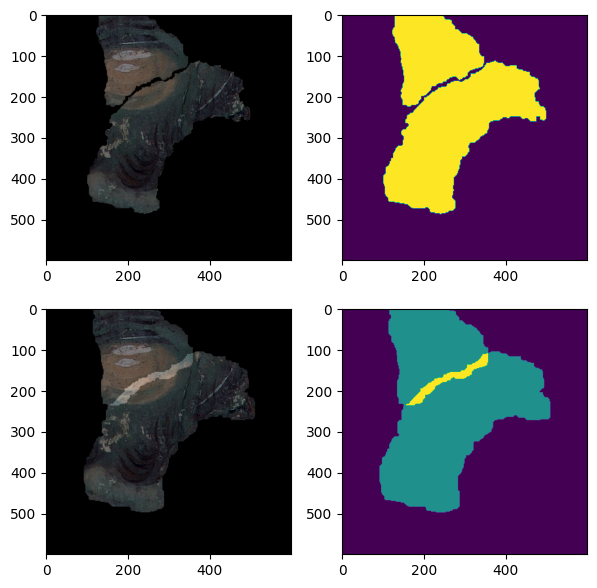

In [32]:
tr = sorted(res, reverse=True, key=lambda val: val.confidence)[0]
print(tr.confidence, tr.angle, tr.x, tr.y)
x, y = tr.x, tr.y
transformed = shift_fragment(rotate_fragment(pad_fragment_to_size(frags[0], 200), tr.angle), -74, -243)
blended = blend_fragments(frags[1], transformed)
visualize_fragment(blended)

# Pairwise 2-stage matching

In [140]:
frags = [
    build_fragment(9, None), 
    build_fragment(11, None), 
#     build_fragment(14, None), 
#     build_fragment(15, None),
#     build_fragment(10, None),
]

In [141]:
start_time = time.time()
ext_frags = [extend_fragment(frag, model) for frag in frags]
print("--- %s seconds ---" % (time.time() - start_time))

--- 10.560958862304688 seconds ---


In [142]:
start_time = time.time()
descriptors, alignments = new_pairwise_alignment(palette,ext_frags)
print("--- %s seconds ---" % (time.time() - start_time))

Computing shape descriptors...
Computing pairwise alignments...
Aligning fragments 0 and 1:


100%|██████████████████████████████████████████████████████████████████████████████| 2479/2479 [00:11<00:00, 224.50it/s]


25
4
--- 26.594480514526367 seconds ---


In [143]:
start_time = time.time()
refined_alignment = {}
for l in range(len(frags)):
    for r in range(l + 1, len(frags)):
        print("Refining transform between {} and {}".format(l, r))
        
        list_of_initial_params = []
        subcurves1 = []
        subcurves2 = []
        for alignment in alignments[(l, r)]:
            line1 = aligned_coords2line(alignment.indices, descriptors[l].edge_coords, left=True)
            line2 = aligned_coords2line(alignment.indices, descriptors[r].edge_coords[::-1], left=False)
            line1 -= ext_frags[l].fragment.shape[0] // 2
            line2 -= ext_frags[r].fragment.shape[0] // 2
            best_transform_params = find_best_transform_ransac(line1, line2)
            cos = best_transform_params[0]
            cos = min(cos, 1)
            cos = max(cos, -1)
            theta, shift_y, shift_x = -np.rad2deg(np.arccos(cos)), best_transform_params[2], best_transform_params[3]
            list_of_initial_params.append((theta, int(shift_x), int(shift_y)))
            subcurves1.append(line1)
            subcurves2.append(line2)
    
        res = match_two_aligned_fragments(
            pad_fragment(ext_frags[l], 200),
            pad_fragment(ext_frags[r], 200),
            list_of_initial_params,
            subcurves1,
            subcurves2
        )
        print(len(res))
        if len(res) > 0:
            tr = sorted(res, reverse=True, key=lambda val: val.confidence)[0]
            refined_alignment[(i, j)] = tr
print("--- %s seconds ---" % (time.time() - start_time))

Refining transform between 0 and 1


100%|█████████████████████████████████████████████████████████████████████████████████| 169/169 [00:02<00:00, 56.96it/s]

2
--- 43.61273217201233 seconds ---


In [145]:
refined_alignment

{(0,
  1): Translation(x=59, y=-278, angle=-177.0, confidence=0.5374374436156218)}

In [149]:
l, r = 0, 1

0.5374374436156218


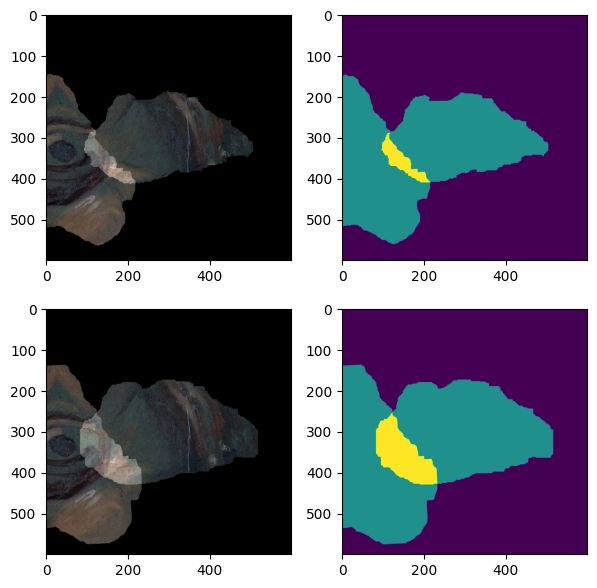

In [151]:
print(tr.confidence)
padded_frag2 = pad_fragment(ext_frags[r], 200)
x, y = tr.x, tr.y
transformed = shift_fragment(rotate_fragment(pad_fragment(ext_frags[l], 200), tr.angle), y, x)
blended = blend_fragments(padded_frag2, transformed)
visualize_fragment(blended)